# Artigo 6
Autor: Bruno Martins Valério Bomfim

Matrícula: 211039297

Disciplina de Aprendizado de Máquina 35M34 (2023.1)

## 1. Introdução
Este artigo refere-se à lição 6 do curso *FastAI for Coders* de Jeremy Howard. Sua finalidade é auxiliar na compreensão de conceitos basilares de árvores de decisão aplicadas a algoritmos de aprendizado de máquina, e aplicá-los na tentativa de resolução de um problema da vida real. 

## 2. Dataset
O dataset alvo deste artigo, chamado [Binary Classification with a Tabular Reservation Cancellation Dataset](https://www.kaggle.com/competitions/playground-series-s3e7/data) foi retirado do próprio Kaggle e proporciona dois recursos tabulares: um de treino e outro de teste. Ele possui dados de um determinado hotel que busca determinar a probabilidade de um futuro cliente cancelar uma reserva mediante dados de clientes anteriores.

>*Customer behavior and booking possibilities have been radically changed by online hotel reservation channels. Cancellations or no-shows cause a significant number of hotel reservations to be canceled. Cancellations can be caused by a variety of factors, such as scheduling conflicts, changes in plans, etc. In many cases, this is made easier by the possibility of doing so free or at a low cost, which is beneficial for hotel guests but less desirable and possibly revenue-diminishing for hotels.* - (Texto retirado da página do dataset).

Descrição das colunas:

- Booking_ID: unique identifier of each booking
- No of adults: Number of adults
- No of children: Number of Children
- noofweekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- noofweek_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- typeofmeal_plan: Type of meal plan booked by the customer:
- requiredcarparking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- roomtypereserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- Market segment type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- noofprevious_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- noofpreviousbookingsnot_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avgpriceper_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- noofspecial_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.

Bibliotecas necessárias:

In [163]:
import os
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import matplotlib.pyplot as plt

Vamos importar o arquivo e conferir algumas características dos nossos dados.

In [151]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/reservation-cancellation-prediction')
else:
    import zipfile,kaggle
    path = Path('reservation-cancellation-prediction')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train__dataset.csv')
tst_df = pd.read_csv(path/'test___dataset.csv')

Agora que os datasets de treino e teste foram importados, vamos analisar alguns detalhes:

### 2.1. Aparência geral do dataset

In [144]:
df.head(6)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
5,2,0,2,3,0,0,1,51,2018,9,18,1,0,0,0,149.40,1,0


### 2.2. Dimensões da tabela

In [145]:
df.shape

(18137, 18)

### 2.3. Aspectos gerais

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18137 entries, 0 to 18136
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          18137 non-null  int64  
 1   no_of_children                        18137 non-null  int64  
 2   no_of_weekend_nights                  18137 non-null  int64  
 3   no_of_week_nights                     18137 non-null  int64  
 4   type_of_meal_plan                     18137 non-null  int64  
 5   required_car_parking_space            18137 non-null  int64  
 6   room_type_reserved                    18137 non-null  int64  
 7   lead_time                             18137 non-null  int64  
 8   arrival_year                          18137 non-null  int64  
 9   arrival_month                         18137 non-null  int64  
 10  arrival_date                          18137 non-null  int64  
 11  market_segment_

Temos 18137 linhas totalmente preenchidas e ocupando 2.5 MB de espaço. Com exceção de avg_price_per_room, que é do tipo float, todas as outras colunas armazenam tipos inteiros.

### 2.4. Estatísticas gerais

In [147]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000
mean,1.846777,0.107515,0.811104,2.208965,0.318465,0.031648,0.336770,85.377405,2017.820698,7.432762,15.660804,0.806197,0.025087,0.022440,0.151403,103.478868,0.617522,0.327618
std,0.516020,0.408901,0.873470,1.426365,0.629140,0.175066,0.772865,86.611736,0.383616,3.076999,8.772788,0.645972,0.156393,0.370078,1.714135,35.474103,0.787941,0.469357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,127.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.270000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


### 2.5. Distribuição dos dados

2    13104
1     3809
3     1150
0       67
4        7
Name: no_of_adults, dtype: int64



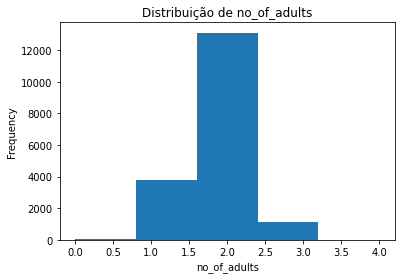

0    16767
1      814
2      544
3       10
9        2
Name: no_of_children, dtype: int64



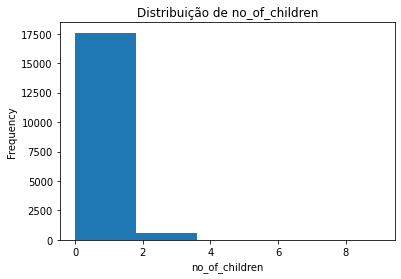

0    8444
1    4985
2    4535
3      84
4      56
5      19
6      13
7       1
Name: no_of_weekend_nights, dtype: int64



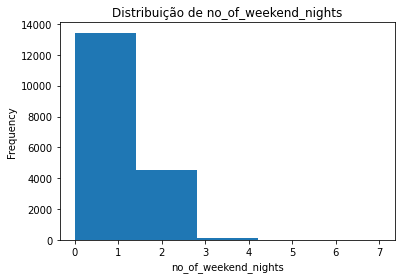

2     5696
1     4727
3     3926
4     1505
0     1208
5      819
6       90
7       57
10      31
8       30
9       19
15       6
11       6
14       5
12       5
13       3
17       3
16       1
Name: no_of_week_nights, dtype: int64



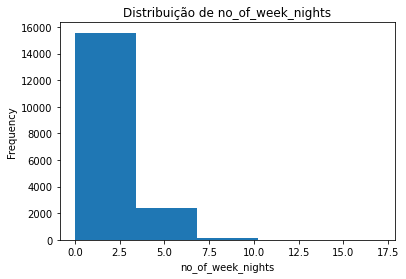

0    13979
1     2543
2     1612
3        3
Name: type_of_meal_plan, dtype: int64



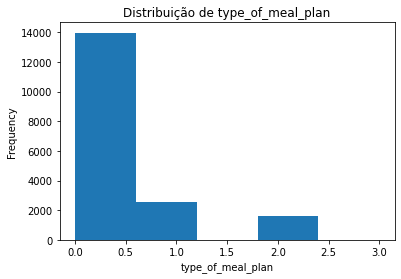

0    17563
1      574
Name: required_car_parking_space, dtype: int64



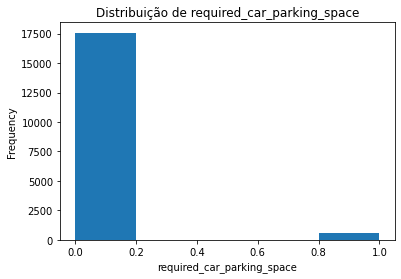

0    14061
1     3031
3      498
2      344
4      123
5       77
6        3
Name: room_type_reserved, dtype: int64



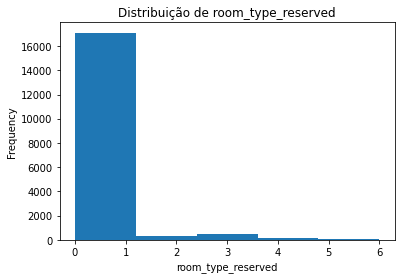

0      643
1      550
3      333
2      332
4      316
      ... 
300      1
352      1
293      1
348      1
325      1
Name: lead_time, Length: 341, dtype: int64



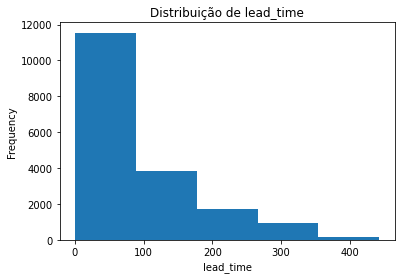

2018    14885
2017     3252
Name: arrival_year, dtype: int64



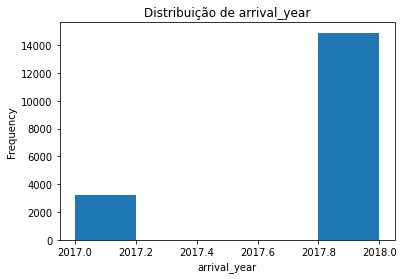

10    2678
9     2301
8     1868
6     1607
12    1535
11    1505
7     1422
4     1386
5     1305
3     1176
2      853
1      501
Name: arrival_month, dtype: int64



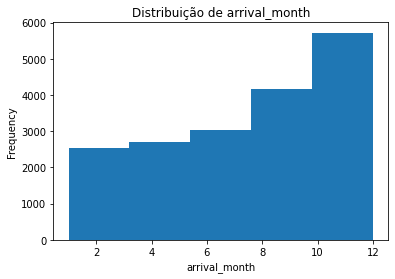

13    702
2     672
17    665
19    657
4     656
16    649
20    642
6     622
30    616
15    614
18    600
12    595
29    594
25    593
8     591
14    590
26    580
11    578
28    575
5     574
1     570
27    566
10    566
21    557
9     552
3     548
24    541
7     537
22    520
23    518
31    297
Name: arrival_date, dtype: int64



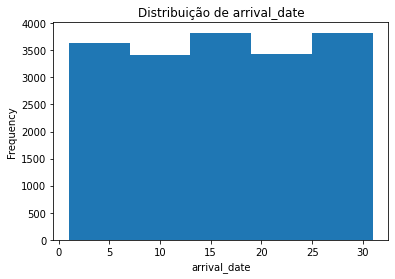

1    11622
0     5238
2     1029
4      198
3       50
Name: market_segment_type, dtype: int64



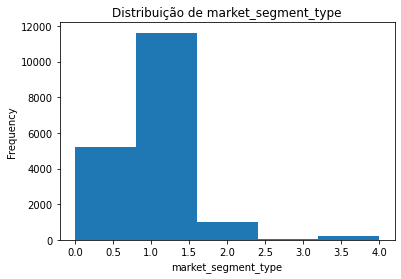

0    17682
1      455
Name: repeated_guest, dtype: int64



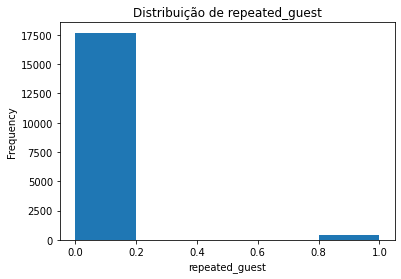

0     17987
1        80
3        23
2        22
11       13
4         6
5         3
13        2
6         1
Name: no_of_previous_cancellations, dtype: int64



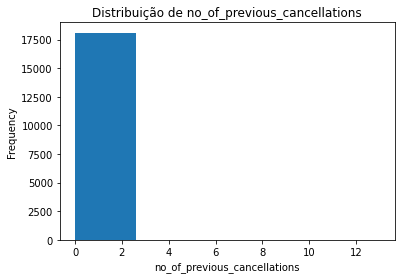

0     17731
1       116
2        54
3        40
4        33
5        29
6        17
8        15
7        13
10        9
11        8
12        7
16        6
9         6
18        5
14        5
13        4
20        4
22        3
23        2
15        2
21        2
17        2
34        1
25        1
26        1
32        1
48        1
58        1
30        1
47        1
46        1
41        1
33        1
27        1
19        1
31        1
24        1
43        1
45        1
50        1
36        1
37        1
44        1
35        1
28        1
51        1
Name: no_of_previous_bookings_not_canceled, dtype: int64



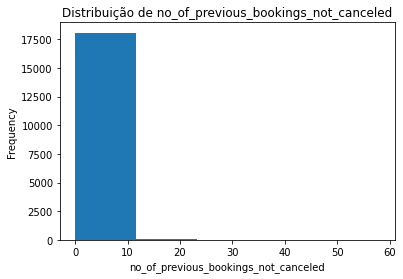

65.00     442
75.00     434
90.00     348
95.00     339
115.00    326
         ... 
53.45       1
170.61      1
74.48       1
56.94       1
148.60      1
Name: avg_price_per_room, Length: 2722, dtype: int64



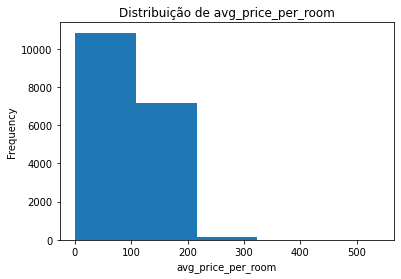

0    9934
1    5637
2    2191
3     323
4      48
5       4
Name: no_of_special_requests, dtype: int64



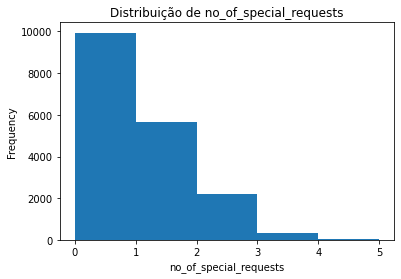

0    12195
1     5942
Name: booking_status, dtype: int64



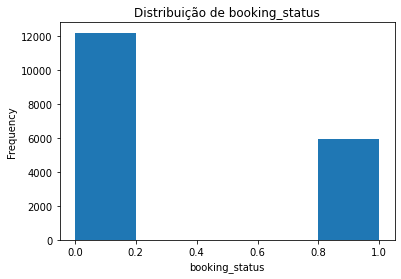

In [172]:
for col in df.columns:
    print(df[col].value_counts(), end='\n\n')
    df[col].plot.hist(bins=5)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribuição de {col}')
    plt.show()

### 2.6. Variáveis dependentes e independentes
O objetivo é definir o book_status para uma determinada entrada de dados, por isso ele é a variável dependente.

As variavéis categóricas estão relacionadas a tipos definidos e limitados de opções. Por exemplo: *room_type_reserved* pode assumir os valores 0, 1, 2, 3, 4, 5, 6. A mesma lógica vale para os outros campos categóricos listados abaixo:

In [142]:
categoricas = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'repeated_guest']
continuas = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights',
             'required_car_parking_space','lead_time', 'arrival_year', 'arrival_month',
             'arrival_date', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
             'avg_price_per_room', 'no_of_special_requests']
dependente = 'booking_status'

## 3. Construindo a árvore de decisão
Vamos dividir o dataset entre treino e validação:

In [174]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
treino_df,validacao_df = train_test_split(df, test_size=0.25)

treino_independentes = treino_df[categoricas + continuas].copy()
treino_dependente = treino_df[dependente]
validacao_independentes = validacao_df[categoricas + continuas].copy()
validacao_dependente = validacao_df[dependente]

Distribuição dos datasets de treino e validação:

array([[<AxesSubplot:title={'center':'no_of_adults'}>, <AxesSubplot:title={'center':'no_of_children'}>,
        <AxesSubplot:title={'center':'no_of_weekend_nights'}>, <AxesSubplot:title={'center':'no_of_week_nights'}>],
       [<AxesSubplot:title={'center':'type_of_meal_plan'}>, <AxesSubplot:title={'center':'required_car_parking_space'}>,
        <AxesSubplot:title={'center':'room_type_reserved'}>, <AxesSubplot:title={'center':'lead_time'}>],
       [<AxesSubplot:title={'center':'arrival_year'}>, <AxesSubplot:title={'center':'arrival_month'}>,
        <AxesSubplot:title={'center':'arrival_date'}>, <AxesSubplot:title={'center':'market_segment_type'}>],
       [<AxesSubplot:title={'center':'repeated_guest'}>, <AxesSubplot:title={'center':'no_of_previous_cancellations'}>,
        <AxesSubplot:title={'center':'no_of_previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'avg_price_per_room'}>],
       [<AxesSubplot:title={'center':'no_of_special_requests'}>, <AxesSubplot:t

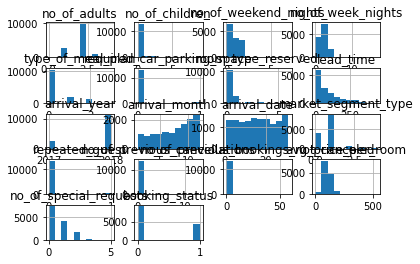

In [181]:
treino_df.hist()

array([[<AxesSubplot:title={'center':'no_of_adults'}>, <AxesSubplot:title={'center':'no_of_children'}>,
        <AxesSubplot:title={'center':'no_of_weekend_nights'}>, <AxesSubplot:title={'center':'no_of_week_nights'}>],
       [<AxesSubplot:title={'center':'type_of_meal_plan'}>, <AxesSubplot:title={'center':'required_car_parking_space'}>,
        <AxesSubplot:title={'center':'room_type_reserved'}>, <AxesSubplot:title={'center':'lead_time'}>],
       [<AxesSubplot:title={'center':'arrival_year'}>, <AxesSubplot:title={'center':'arrival_month'}>,
        <AxesSubplot:title={'center':'arrival_date'}>, <AxesSubplot:title={'center':'market_segment_type'}>],
       [<AxesSubplot:title={'center':'repeated_guest'}>, <AxesSubplot:title={'center':'no_of_previous_cancellations'}>,
        <AxesSubplot:title={'center':'no_of_previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'avg_price_per_room'}>],
       [<AxesSubplot:title={'center':'no_of_special_requests'}>, <AxesSubplot:t

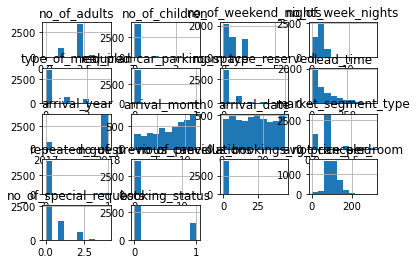

In [182]:
validacao_df.hist()

Os histogramas indicam que os dados estão desbalanceados. Sempre há um valor preponderante em cada coluna.

Função auxiliar para exibir a árvore de decisão:

In [183]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

Vamos utilizar o objeto DecisionTreeClassifier, da sklearn.

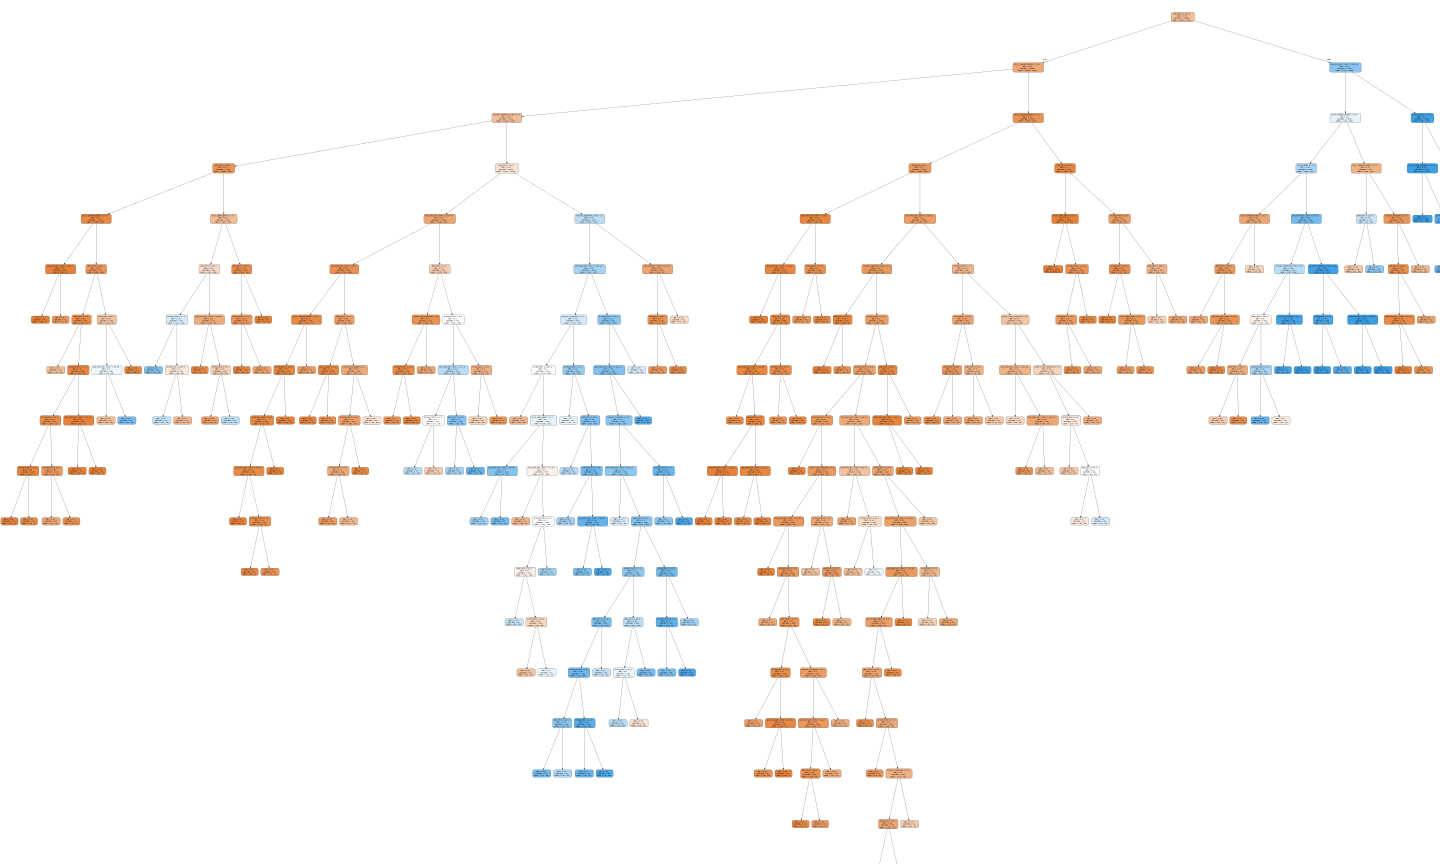

In [176]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(treino_independentes, treino_dependente)
draw_tree(m, treino_independentes, size=20)

In [177]:
mean_absolute_error(validacao_dependente, m.predict(validacao_independentes))

0.15611907386990076

## 4. Construção da random forest

In [178]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(treino_independentes, treino_dependente);
mean_absolute_error(validacao_dependente, rf.predict(validacao_independentes))

0.11223814773980155

A função feature_importances revela quais variáveis independentes foram as mais importantes para o modelo:

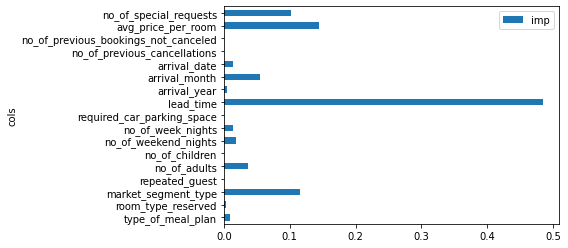

In [179]:
pd.DataFrame(dict(cols=treino_independentes.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

## 5. Inferência

Vamos criar árvores com diversos números mínimos de folhas e analisar o erro absoluto médio e índice de gini.

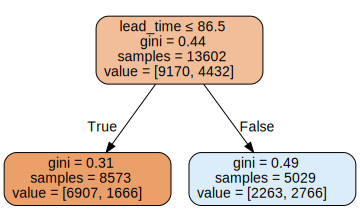

In [188]:
t1 = DecisionTreeClassifier(min_samples_leaf=5000)
t1.fit(treino_independentes, treino_dependente)
draw_tree(t1, treino_independentes, size=20)

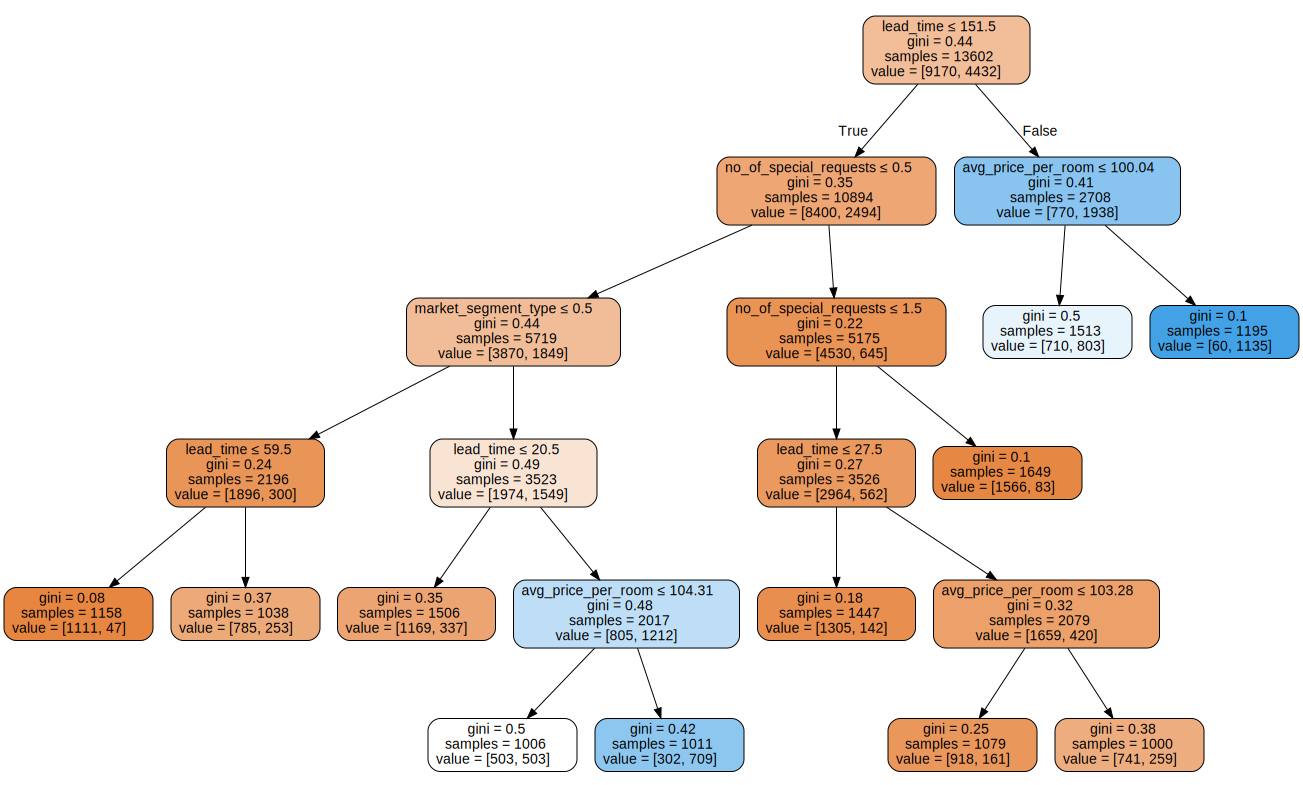

In [189]:
t2 = DecisionTreeClassifier(min_samples_leaf=1000)
t2.fit(treino_independentes, treino_dependente)
draw_tree(t2, treino_independentes, size=20)

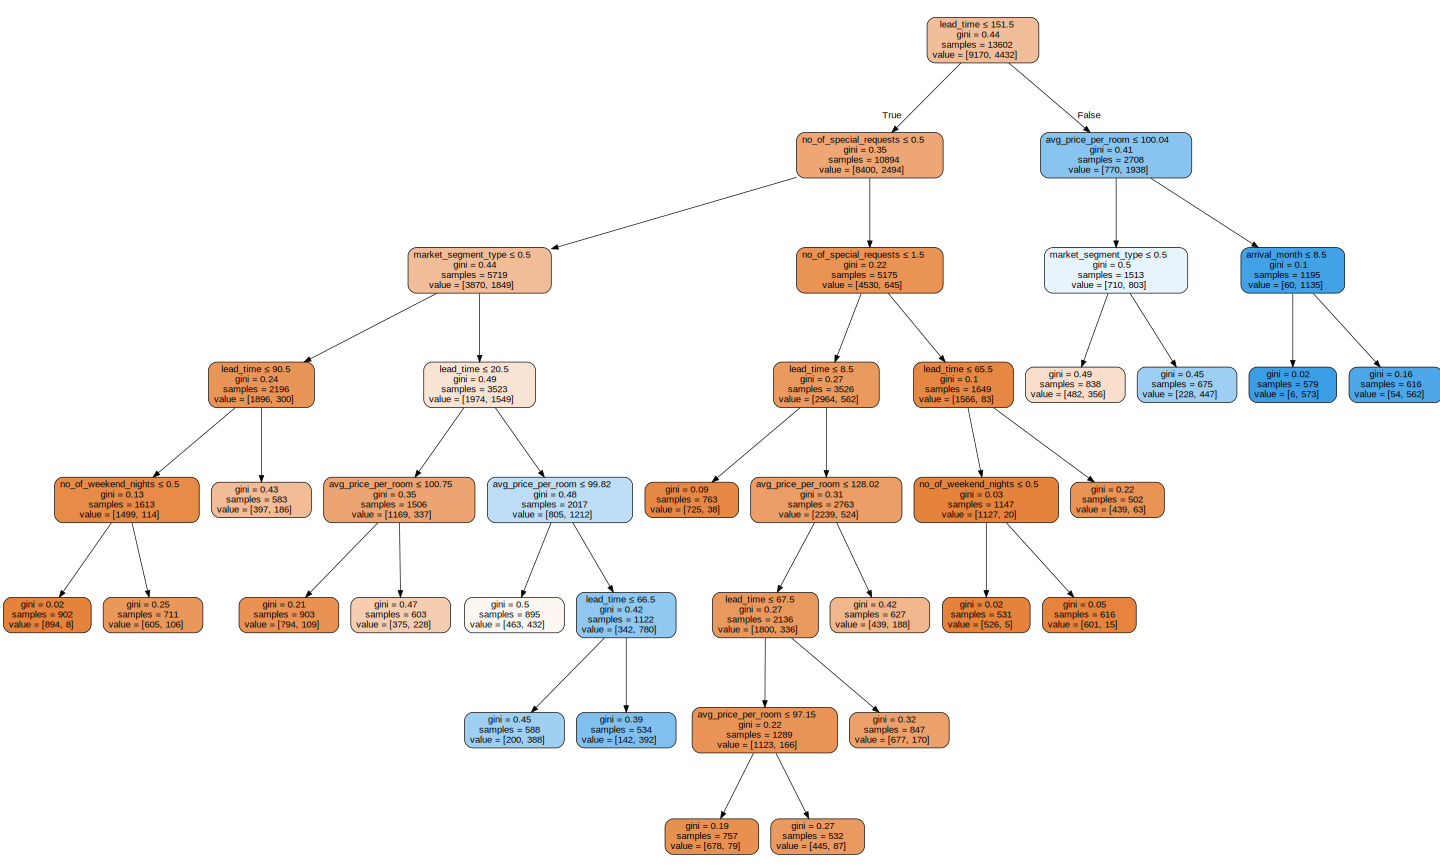

In [190]:
t3 = DecisionTreeClassifier(min_samples_leaf=500)
t3.fit(treino_independentes, treino_dependente)
draw_tree(t3, treino_independentes, size=20)

In [191]:
mean_absolute_error(validacao_dependente, t1.predict(validacao_independentes))

0.2820286659316428

In [192]:
mean_absolute_error(validacao_dependente, t2.predict(validacao_independentes))

0.20264608599779493

In [193]:
mean_absolute_error(validacao_dependente, t3.predict(validacao_independentes))

0.1977949283351709

Podemos notar que menores valores de número mínimo de folhas resulta em resultados mais precisos (menor erro absoluto médio).

## 6. Deploy
Você pode acessar o deploy no HugginFace por [aqui](https://huggingface.co/spaces/brunomartins/lesson6).

## 7. Considerações finais
Nesse artigo pudemos explorar questões fundamentais de árvores de decisão e suas propriedades nas random forests. Embora o dataset não estivesse balanceado, pudemos obter insights valiosos.

## Bibliografia
[Jeremy Howard and Sylvain Gugge - FastBook](https://github.com/fastai/fastbook)

[How random forests really work? - Jeremy Howard](https://www.kaggle.com/code/jhoward/how-random-forests-really-work/)